In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import glob
from radioReduction import *
from astropy.stats import LombScargle
from scipy import optimize
from scipy.interpolate import make_interp_spline, BSpline


In [3]:
# Stokes V
dt = glob.glob('1315/dataTables/*-LLRR.dat')

re = []
ure = []
mjd = []

for i in dt:
    x = pd.read_table(i)
    m,r,e = meanData(x)
    mjd.append(m)
    re.append(r)
    ure.append(e)
avg = pd.DataFrame(data={'mjd':mjd,'re':re,'ure':ure})
avg = avg.sort_values('mjd')
avg = avg.reset_index(drop=True)


# Loading the background sources
s1 = pd.read_csv('1315/s1_lc.csv',sep=' ')
s2 = pd.read_csv('1315/s2_lc.csv',sep=' ')
s3 = pd.read_csv('1315/s3_lc.csv',sep=',')

# Putting all the sources into one array
All = pd.merge_asof(s2.sort_values('mjd'),s3.sort_values('mjd'),direction='nearest',on='mjd')
All = pd.merge_asof(All,s1.sort_values('mjd'),direction='nearest',on='mjd')
All = All.drop(columns={'Unnamed: 0_x','Unnamed: 0_y','Unnamed: 0'})

# Filling in missing epochs with 
backGround = All.rename(columns={'re_x':'s2_re', 'ure_x':'s2_ure', 're_y':'s3_re', 'ure_y':'s3_ure', 're':'s1_re','ure':'s1_ure'})

# Stokes V
ll = glob.glob('1315/dataTables/*-LL.dat')
rr = glob.glob('1315/dataTables/*-RR.dat')

re = []
ure = []
mjd = []

for i in ll:
    x = pd.read_table(i)
    m,r,e = meanData(x)
    mjd.append(m)
    re.append(r)
    ure.append(e)
ll = pd.DataFrame(data={'mjd':mjd,'re':re,'ure':ure})
ll = ll.sort_values('mjd')
ll = ll.reset_index(drop=True)

re = []
ure = []
mjd = []
for i in rr:
    x = pd.read_table(i)
    m,r,e = meanData(x)
    mjd.append(m)
    re.append(r)
    ure.append(e)
    
rr = pd.DataFrame(data={'mjd':mjd,'re':re,'ure':ure})
rr = rr.sort_values('mjd')
rr = rr.reset_index(drop=True)

stV = (rr['re']-ll['re'])*0.5
stI = (rr['re']+ll['re'])*0.5
stErr = np.sqrt(rr['ure']**2+ll['ure']**2)*.5


# Getting the two different basebands

LOW = glob.glob('1315/dataTables/*-5GHz.dat')
HIGH = glob.glob('1315/dataTables/*-7GHz.dat')

re = []
ure = []
mjd = []

for i in LOW:
    x = pd.read_table(i)
    m,r,e = meanData(x)
    mjd.append(m)
    re.append(r)
    ure.append(e)
low = pd.DataFrame(data={'mjd':mjd,'re':re,'ure':ure})
low = low.sort_values('mjd')
low = low.reset_index(drop=True)

re = []
ure = []
mjd = []
for i in HIGH:
    x = pd.read_table(i)
    m,r,e = meanData(x)
    mjd.append(m)
    re.append(r)
    ure.append(e)
    
high = pd.DataFrame(data={'mjd':mjd,'re':re,'ure':ure})
high = high.sort_values('mjd')
high = high.reset_index(drop=True)





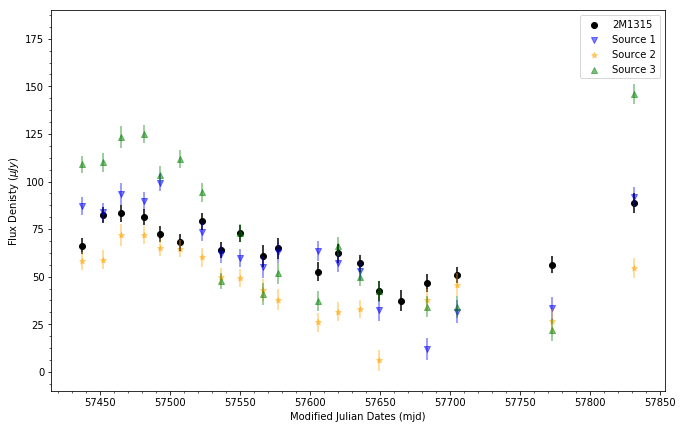

In [4]:
# Plotting the sources
plt.figure(figsize=(11,7))
plt.scatter(avg['mjd'],avg['re'],color='black',marker='o',label='2M1315')
plt.errorbar(avg['mjd'],avg['re'],color='black',yerr=avg['ure'],linestyle='None',label='_nolegend_')

#plt.errorbar(avg['mjd'],stI,color='red',yerr=stErr,linestyle='None',fmt='o',label='Stokes I')

sources = [s1,s2,s3]
colors = ['blue','orange','green']
markers = ['v','*','^']
j = 0
for i in sources:
    plt.scatter(i['mjd'],i['re'],color=colors[j],marker=markers[j],label='Source %s'%(j+1),alpha=0.5)
    plt.errorbar(i['mjd'],i['re'],color=colors[j],yerr=i['ure'],linestyle='None',label='_nolegend_',alpha=0.5)
    j = j + 1
plt.legend(loc=1)
plt.xlabel('Modified Julian Dates (mjd)')
plt.ylabel('Flux Denisty ($\mu Jy$)')
plt.minorticks_on()
plt.ylim(-10,190)
plt.savefig('plots/1315_background.png')
plt.show()

In [5]:
# Creating an average light curves of all the background sources
avgBack = (s1['re']+s2['re']+s3['re'])/3
avgBack[5] = (s2['re'].iloc[5]+s3['re'].iloc[5])/2
avgBackErr = np.sqrt(s1['ure']**2+s2['ure']**2+s3['ure']**2)/3
avgBackErr[5] = np.sqrt(s2['ure'].iloc[5]**2+s3['ure'].iloc[5]**2)/2

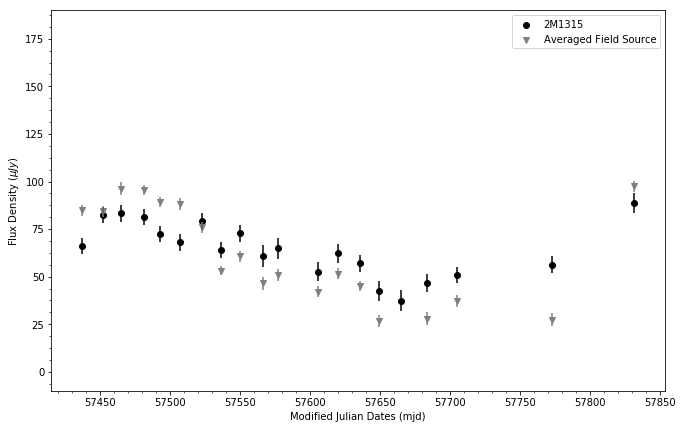

In [146]:
# Plotting the average background light curve
plt.figure(figsize=(11,7))
plt.scatter(avg['mjd'],avg['re'],color='black',marker='o',label='2M1315')
plt.errorbar(avg['mjd'],avg['re'],color='black',yerr=avg['ure'],linestyle='None',label='_nolegend_')
plt.scatter(s2['mjd'],avgBack,color='gray',marker='v',label='Averaged Field Source')
plt.errorbar(s2['mjd'],avgBack,yerr=avgBackErr,color='gray',linestyle='None',label='_nolabel_')
plt.legend(loc='best')
plt.xlabel('Modified Julian Dates (mjd)')
plt.ylabel('Flux Density ($\mu Jy$)')
plt.ylim(-10,190)
plt.minorticks_on()
plt.savefig('plots/1315_avgFieldSource.png')
plt.show()

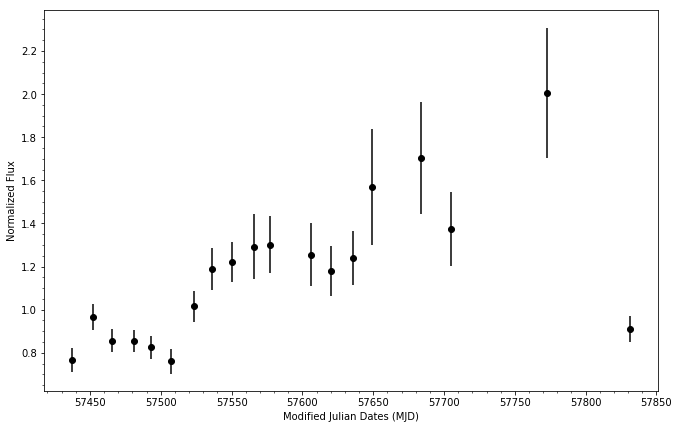

In [11]:
plt.figure(figsize=(11,7))
plt.errorbar(time,norm,yerr=normErr,color='black',fmt='o')
plt.minorticks_on()
plt.ylabel('Normalized Flux')
plt.xlabel('Modified Julian Dates (MJD)')
plt.savefig('plots/1315_Normalized.png')
plt.show()


In [8]:
avgNorm = np.nanmean(norm)
avgNormErr = 1/np.sqrt(np.sum(1/normErr**2))


chi2_avg = np.sum(np.square((norm-avgNorm)/normErr))
print(chi2_avg)

270.28720515811847


In [10]:
avg

1.1730689982200235

In [ ]:
plt.figure(figsize=(11,7))
plt.errorbar(time,stV,yerr=stErr,color='black',fmt='o')
plt.minorticks_on()
plt.ylabel('Normalized Flux')
plt.xlabel('Modified Julian Dates (MJD)')
# plt.savefig('plots/1315_Normalized.png')
plt.show()

In [148]:
s1_ll = pd.read_table('1315/source_1/*-LL.dat')
s1_rr = pd.read_table('1315/source_1/*-RR.dat')

s1_ll = binn


s2_ll = pd.read_table('1315/source_2/*-LL.dat')
s2_rr = pd.read_table('1315/source_2/*-RR.dat')

s3_ll = pd.read_table('1315/source_3/*-LL.dat')
s3_rr = pd.read_table('1315/source_3/*-RR.dat')

FileNotFoundError: File b'1315/source_1/*-LL.dat' does not exist

In [16]:
avgBackErr,avgBack

(0     2.682479
 1     2.878764
 2     3.375573
 3     2.732596
 4     2.656643
 5     3.203451
 6     2.873679
 7     2.543257
 8     2.689271
 9     3.344616
 10    3.194339
 11    2.980177
 12    2.887108
 13    2.719703
 14    3.154638
 15         NaN
 16    3.301491
 17    3.391761
 18    3.466429
 19    2.997364
 Name: ure, dtype: float64, 0     84.810888
 1     84.289705
 2     96.300599
 3     95.527533
 4     89.421474
 5     88.213508
 6     76.037109
 7     53.190416
 8     60.617062
 9     46.474050
 10    50.728279
 11    42.176130
 12    51.624608
 13    45.198172
 14    26.859914
 15          NaN
 16    27.926456
 17    37.185994
 18    27.294612
 19    97.446113
 Name: re, dtype: float64)

In [19]:
norm,normErr

(0     0.767568
 1     0.965711
 2     0.856757
 3     0.854067
 4     0.825093
 5     0.761281
 6     1.015356
 7     1.190165
 8     1.219409
 9     1.292417
 10    1.301268
 11    1.255759
 12    1.179816
 13    1.238745
 14    1.570194
 15         NaN
 16    1.705739
 17    1.372920
 18    2.006177
 19    0.909869
 Name: re, dtype: float64, 0     0.056626
 1     0.061683
 2     0.054011
 3     0.051172
 4     0.054414
 5     0.057342
 6     0.071087
 7     0.098006
 8     0.092882
 9     0.150558
 10    0.133174
 11    0.144147
 12    0.114491
 13    0.126122
 14    0.268256
 15         NaN
 16    0.259723
 17    0.170692
 18    0.302357
 19    0.059818
 dtype: float64)

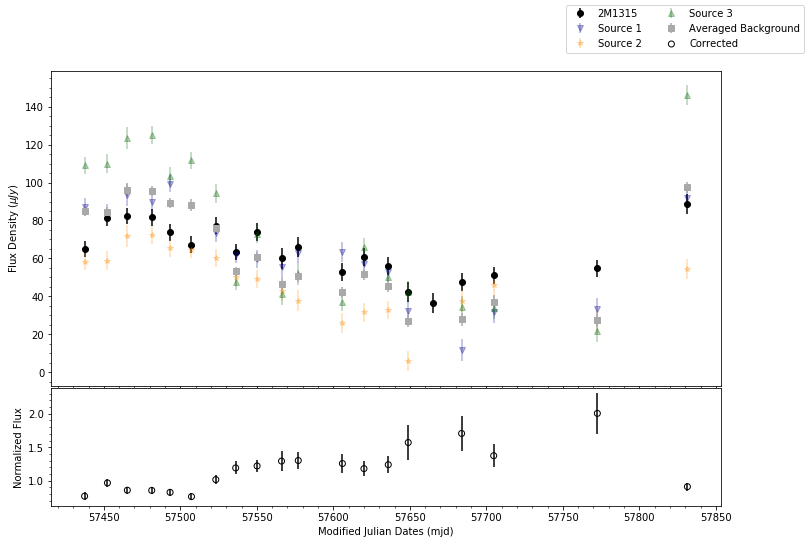

In [24]:
# Calculating ration between 1315 and avg field sources
norm = stI/avgBack
normErr = np.abs(norm)*np.sqrt((stErr/stI)**2+(avgBackErr/avgBack)**2)
time = avg['mjd']

# Plotting the sources and the standard deviation
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(12,8),sharex=True,gridspec_kw={'hspace':0.01,'height_ratios':[4,1.5]})

# Plotting the Sources
sources = [s1,s2,s3]
colors = ['darkblue','darkorange','darkgreen']
markers = ['v','*','^']
legend = []
legend.append(ax[0].errorbar(time,stI,yerr=stErr,color='black',linestyle='none',marker='o',label='2M1315'))
j = 0
for i in sources:
    legend.append(ax[0].errorbar(i['mjd'],i['re'],yerr=i['ure'],color=colors[j],linestyle='None',marker=markers[j],label='Source %s'%(j+1),alpha=0.3))
    j = j + 1
legend.append(ax[0].errorbar(s2['mjd'],avgBack,yerr=avgBackErr,linestyle='None',color='darkgray',marker='s',label='Averaged Background'))
ax[0].set_ylabel('Flux Density ($\mu Jy$)')
ax[0].minorticks_on()


# Plotting normalized values
legend.append(ax[1].scatter(avg['mjd'],norm,color='k',marker='o',facecolors='none',edgecolors='black',label='Corrected'))
ax[1].errorbar(avg['mjd'],norm,color='k',yerr=normErr,linestyle='None',label='_nolegend_')
ax[1].minorticks_on()
ax[1].set_ylabel('Normalized Flux')


# # Making a plot for stokes V
# ax[2].axhline(y=0,linestyle='dashed',color='k')
# ax[2].set_ylabel('Stokes V')
# ax[2].set_ylim(-30,30)
# ax[2].minorticks_on()

# Getting labels for the legend
h,l1 = ax[0].get_legend_handles_labels()
h,l2 = ax[1].get_legend_handles_labels()
# h,l3 = ax[2].get_legend_handles_labels()
labels = np.concatenate([l1,l2])

# Creating the legend and labeling axis
fig.legend(legend,labels,loc='upper right',ncol=2)
plt.xlabel('Modified Julian Dates (mjd)')
plt.savefig('plots/1315_divided.png')
plt.show()

In [ ]:
'''
Reduced Chi-square on the norm 
'''

chi2 = np.sum(np.square(norm-norm.mean())/normErr**2)/(len(norm)-1)
print(chi2)

In [ ]:
# Calculating spectral index
alpha = np.log10(ratio)/np.log10(7/5)

# Calculating Error on alpha
errLogR = ratioErr/ratio
alphaErr = np.abs(1/np.log10(7/5))*errLogR

In [ ]:
# PLotting alpha values
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(11,8),gridspec_kw = {'hspace':.05,'height_ratios':[4,1]},sharex=True)
ax[0].errorbar(low['mjd'],low['re'],yerr=low['ure'],color='darkgreen',fmt='o',linestyle='None',label='5 GHz')
ax[0].errorbar(high['mjd'],high['re'],yerr=high['ure'],color='darkorange',fmt='o',linestyle='None',label='7 GHz')


ax[0].legend(loc='best')
ax[0].set_ylabel('Flux Density ($mJy$)')
ax[0].set_ylim(0,120)
ax[0].minorticks_on()

ax[1].errorbar(low['mjd'],alpha,color='darkred',marker='o',yerr=alphaErr,linestyle='None')
ax[1].set_ylabel('Spectral Index $\\alpha$')
ax[1].axhline(y=0,linestyle='dashed',color='k')

plt.xlabel('Modified Julian Dates (mjd)')
plt.savefig('plots/1315_SED_Alpha.png')
plt.show()

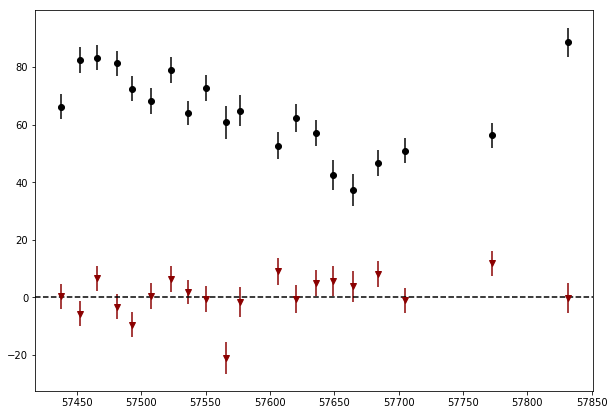

In [150]:
plt.figure(figsize=(10,7))
plt.errorbar(rr['mjd'],stV,yerr=stErr,fmt='v',linestyle='None',color='darkred')
plt.errorbar(avg['mjd'],avg['re'],yerr=avg['ure'],fmt='o',linestyle='None',color='black')
plt.axhline(y=0,color='k',linestyle='dashed')
plt.show()

In [151]:
import datetime
from astropy.time import Time

In [152]:
#x = [12[5[5]]]
time = [datetime.time(2,2,33),
        datetime.time(0,9,11),
        datetime.time(0,21,57),
        datetime.time(22,46,15),
        datetime.time(22,35,19),
        datetime.time(22,30,10),
        datetime.time(20,6,28),
        datetime.time(19,46,14),
        datetime.time(19,47,1),
        datetime.time(18,59,7),
        datetime.time(17,29,56),
        datetime.time(14,11,5),
        datetime.time(15,39,3),
        datetime.time(13,13,7),
        datetime.time(14,21,39),
        datetime.time(12,35,39),
        datetime.time(11,37,1),
        datetime.time(10,59,26),
        datetime.time(5,3,5),
        datetime.time(1,22,52)]

In [153]:
y = avg['re']

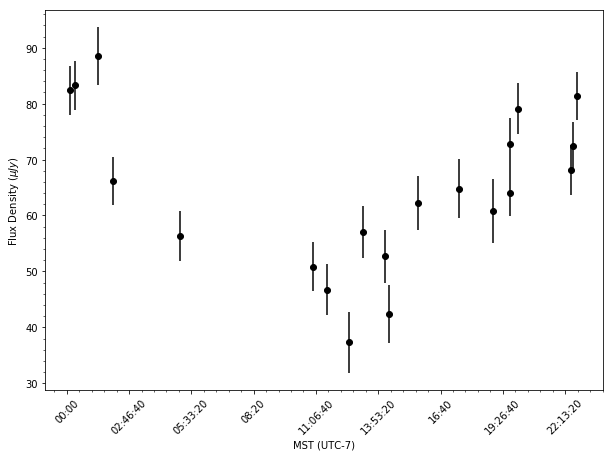

In [154]:
# Plotting data
plt.figure(figsize=(10,7))
plt.errorbar(time,y,yerr=avg['ure'],color='k',marker='o',linestyle='None')

plt.xlabel('MST (UTC-7)')
plt.ylabel('Flux Density ($\mu Jy$)')
plt.minorticks_on()
plt.xticks(rotation=45)
plt.savefig('plots/1315_TimeOfDay.png')
plt.show()

In [155]:
# Stokes V
ll = glob.glob('1315/dataTables/*-LL.dat')
rr = glob.glob('1315/dataTables/*-RR.dat')

re = []
ure = []
mjd = []

for i in ll:
    x = pd.read_table(i)
    m,r,e = meanData(x)
    mjd.append(m)
    re.append(r)
    ure.append(e)
ll = pd.DataFrame(data={'mjd':mjd,'re':re,'ure':ure})
ll = ll.sort_values('mjd')
ll = ll.reset_index(drop=True)

re = []
ure = []
mjd = []
for i in rr:
    x = pd.read_table(i)
    m,r,e = meanData(x)
    mjd.append(m)
    re.append(r)
    ure.append(e)
    
rr = pd.DataFrame(data={'mjd':mjd,'re':re,'ure':ure})
rr = rr.sort_values('mjd')
rr = rr.reset_index(drop=True)

In [156]:
# Calculating the stokes V
stI = (rr['re']+ll['re'])*.5
stV = (rr['re']-ll['re'])*.5
frac = stV/stI
stErr = np.sqrt(rr['ure']**2+ll['ure']**2)*.5
time = rr['mjd']

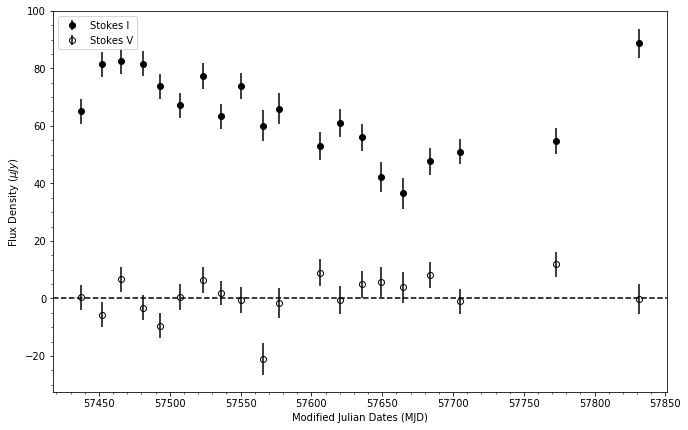

In [157]:
plt.figure(figsize=(11,7))
plt.errorbar(time,stI,yerr=stErr,color='k',marker='o',linestyle='none',label='Stokes I')
plt.errorbar(time,stV,yerr=stErr,color='k',marker='o',markerfacecolor='None',label='Stokes V',linestyle='None')


plt.axhline(y=0,color='k',linestyle='dashed')
plt.minorticks_on()
plt.xlabel('Modified Julian Dates (MJD)')
plt.ylabel('Flux Density ($\mu Jy$)')
plt.legend(loc='best')
plt.savefig('plots/1315_Stokes.png')
plt.show()

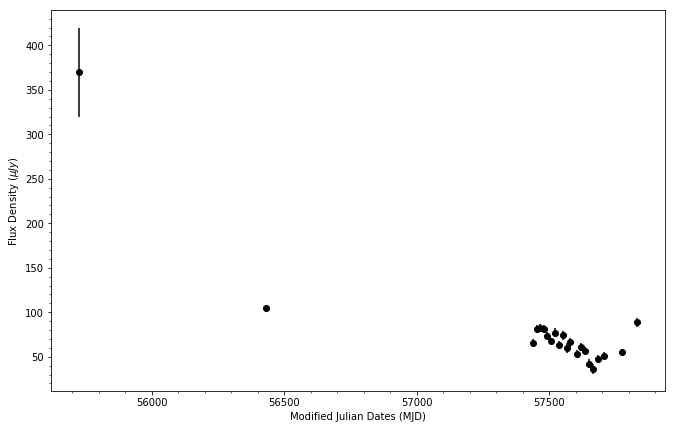

In [21]:
plt.figure(figsize=(11,7))
plt.errorbar(55726,370,yerr=50,color='k',marker='o',linestyle='none')
plt.errorbar(56430.184,104.83,yerr=2.43,color='k',marker='o',linestyle='none')
plt.errorbar(time,stI,yerr=stErr,color='k',marker='o',linestyle='none')

plt.minorticks_on()
plt.xlabel('Modified Julian Dates (MJD)')
plt.ylabel('Flux Density ($\mu Jy$)')
plt.savefig('plots/1315_AllObs.png')
plt.show()

In [7]:
'''
Looking at all the sources
'''

s1_ll = lightCurve('1315/source_1/*-LL.dat')
s1_rr = lightCurve('1315/source_1/*-RR.dat')

s2_ll = lightCurve('1315/source_2/*-LL.dat')
s2_rr = lightCurve('1315/source_2/*-RR.dat')

s3_ll = lightCurve('1315/source_3/*-LL.dat')
s3_rr = lightCurve('1315/source_3/*-RR.dat')



In [67]:
s1V = (s1_rr['re']-s1_ll['re'])*.5
s2V = (s2_rr['re']-s2_ll['re'])*.5
s3V = (s3_rr['re']-s3_ll['re'])*.5

s1V_err = (np.sqrt(s1_rr['ure']**2+s1_ll['ure']**2))*0.5
s2V_err = (np.sqrt(s2_rr['ure']**2+s2_ll['ure']**2))*0.5
s3V_err = (np.sqrt(s3_rr['ure']**2+s3_ll['ure']**2))*0.5

s1v = pd.DataFrame(data={'mjd':s1_ll['mjd'],'re':s1V,'ure':s1V_err})
s2v = pd.DataFrame(data={'mjd':s2_ll['mjd'],'re':s2V,'ure':s2V_err})
s3v = pd.DataFrame(data={'mjd':s3_ll['mjd'],'re':s3V,'ure':s3V_err})



In [68]:
s1v

,mjd,re,ure
0,57437.410424,2.120903,4.335930
1,57452.331734,-5.914938,4.388582
2,57465.340582,-0.079386,4.316907
3,57481.274103,-5.642813,4.292222
4,57493.266493,-6.043347,4.342725
5,57523.163189,-7.658726,4.547872
6,57536.149082,-0.640769,4.239695
7,57550.149690,0.494024,4.569891
8,57566.116430,2.261565,5.479740
9,57577.054516,3.482136,5.315309


In [137]:
avgV = pd.merge_asof(left=s2v,right=s3v,on='mjd',allow_exact_matches=True)
avgV = pd.merge(left=s1v,right=avgV,on='mjd',copy=False,how='outer')
avgV = avgV.sort_values('mjd')
dates = pd.DataFrame(data={'mjd':avg['mjd']})
avgV = pd.merge(left=dates,right=avgV,on='mjd',how='right',validate='one_to_one')
avgV = avgV.sort_values('mjd')
print(avgV)




             mjd        re       ure       re_x     ure_x       re_y     ure_y
1   57437.410424  2.120903  4.335930  -2.756729  4.337251  -9.351812  4.339136
2   57452.331734 -5.914938  4.388582   4.868266  4.391406   1.889807  4.390737
3   57465.340582 -0.079386  4.316907  -0.241566  4.317316  -5.657880  4.318247
4   57481.274103 -5.642813  4.292222   2.804203  4.292386   0.185681  4.293374
5   57493.266493 -6.043347  4.342725   1.426903  4.340605  -0.624137  4.341896
6   57507.262916       NaN       NaN  -3.289874  4.420833  -1.293507  4.420693
7   57523.163189 -7.658726  4.547872  -6.327730  4.547912  -3.191441  4.548329
8   57536.149082 -0.640769  4.239695   0.683844  4.241352  -6.593611  4.239877
9   57550.149690  0.494024  4.569891  -1.233535  4.567281  -4.818568  4.571129
10  57566.116430  2.261565  5.479740  -1.937046  5.480735  -3.935969  5.480789
11  57577.054516  3.482136  5.315309  -3.089262  5.315609  -3.332262  5.317197
12  57605.916385 -1.760039  4.788819 -10.591920  4.7

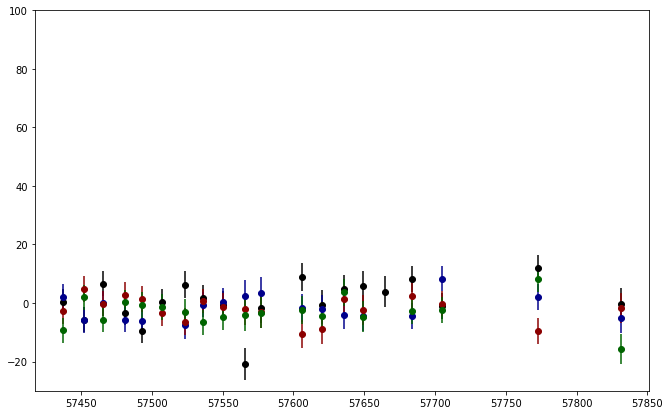

In [160]:
plt.figure(figsize=(11,7))
plt.errorbar(time,stV,yerr=stErr,color='k',fmt='o',linestyle='none')
plt.errorbar(avgV['mjd'],avgV['re'],yerr=avgV['ure'],color='darkblue',fmt='o',linestyle='none')
plt.errorbar(avgV['mjd'],avgV['re_x'],yerr=avgV['ure_x'],color='darkred',fmt='o',linestyle='none')
plt.errorbar(avgV['mjd'],avgV['re_y'],yerr=avgV['ure_y'],color='darkgreen',fmt='o',linestyle='none')
plt.ylim(-30,100)
plt.show()

In [161]:
# Creating an average light curves of all the background sources
avgBack_V = (avgV['re']+avgV['re_x']+avgV['re_y'])/3
avgBack_V[5] = (avgV['re_x'].iloc[5]+avgV['re_y'].iloc[5])/2
avgBack_Verr = np.sqrt(avgV['ure']**2+avgV['ure_x']**2+avgV['ure_y']**2)/3
avgBack_Verr[5] = np.sqrt(avgV['ure_x'].iloc[5]**2+avgV['ure_y'].iloc[5]**2)/2

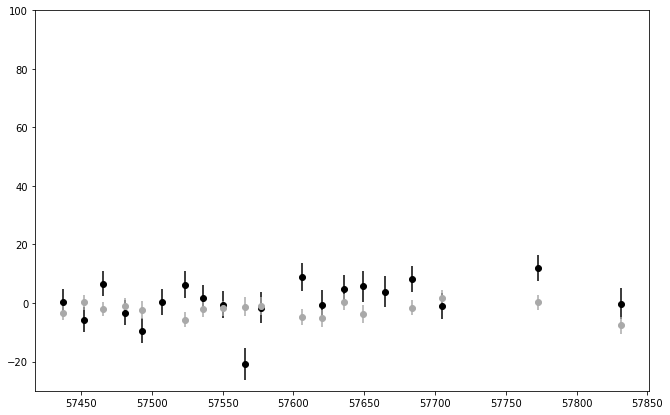

In [162]:
plt.figure(figsize=(11,7))
plt.errorbar(time,stV,yerr=stErr,color='k',fmt='o',linestyle='none')
plt.errorbar(avgV['mjd'],avgBack_V,yerr=avgBack_Verr,color='darkgray',fmt='o',linestyle='none')
plt.ylim(-30,100)
plt.show()

In [165]:
normV = stV/avgBack_V
normV_err = np.abs(normV)*np.sqrt((stErr/stV)**2+(avgBack_Verr/avgBack_V)**2)


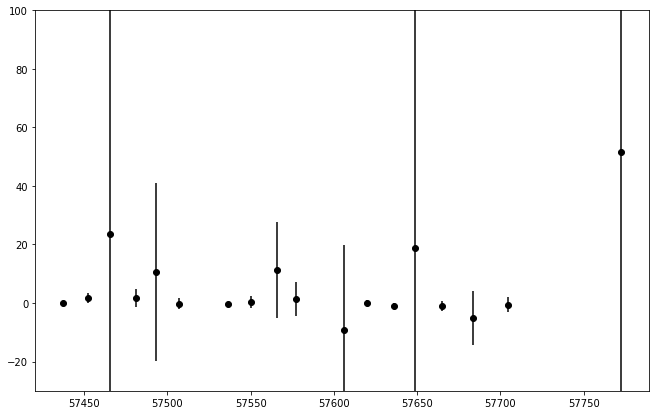

In [166]:
plt.figure(figsize=(11,7))
plt.errorbar(time,normV,yerr=normV_err,color='k',fmt='o',linestyle='none')
plt.ylim(-30,100)
plt.show()